In [1]:
!pip install pybullet imageio-ffmpeg

import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 7.1 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/Gaianeve/Real_Mega_Fufi.git
%cd Real_Mega_Fufi/Robot/1LegTrail/

Cloning into 'Real_Mega_Fufi'...
remote: Enumerating objects: 1408, done.
remote: Counting objects: 100% (392/392), done.
remote: Compressing objects: 100% (364/364), done.
remote: Total 1408 (delta 290), reused 27 (delta 27), pack-reused 1016 (from 3)
Receiving objects: 100% (1408/1408), 15.33 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (919/919), done.
/content/Real_Mega_Fufi/Robot/1LegTrail


In [213]:
import numpy as np
import imageio_ffmpeg
import pybullet as p
import math

# Configura la simulazione e la fotocamera
p.connect(p.DIRECT)  # Usa la modalità senza GUI per evitare un impatto sulle prestazioni
p.resetSimulation() # Lui va chiamato la mattina appena apri il computer
p.setGravity(0, 0, -9.81)

# Aggiungi il percorso dei dati PyBullet
p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [214]:
plane_pos = [0,0,0]
plane = p.loadURDF("plane.urdf", plane_pos, useFixedBase=True)

# position of the base of the model
PIP_position = [0,0,0]
orientation  = [0,0,0]
PIP_orientation = p.getQuaternionFromEuler(orientation)
PIPPA_id = p.loadURDF("PIPPA_oneleg.urdf", basePosition = PIP_position, baseOrientation = PIP_orientation, \
                      useFixedBase=False)


In [215]:
#change colors
p.changeVisualShape(PIPPA_id, -1, rgbaColor=[1, 0.65, 0, 1]) #terreno arancione
p.changeVisualShape(PIPPA_id, 0, rgbaColor=[0.5, 1, 0.5, 1]) #colonna verdino
p.changeVisualShape(PIPPA_id, 1, rgbaColor=[0.5, 0.8, 1, 1]) #colonna azzurrino

In [216]:
link_name_to_index = {p.getBodyInfo(PIPPA_id)[0].decode('UTF-8'):-1,}

for id in range(p.getNumJoints(PIPPA_id)):
  name = p.getJointInfo(PIPPA_id, id)[12].decode('UTF-8')
  link_name_to_index[name] = id

angular_damping = 0.6
restitution_out = 0
for link_index in range(-1, 2):
  print(link_index)
  p.changeDynamics(
    bodyUniqueId=PIPPA_id,
      linkIndex=link_index,
      angularDamping=angular_damping,
      restitution = restitution_out
  )


-1
0
1


In [217]:
#get initial position (rest)
column_position, _ = p.getBasePositionAndOrientation(PIPPA_id)
#externale force due to seismic motion
force_position = column_position

#joint initial orientation and coordinate
joint_position, orientation = p.getLinkState(PIPPA_id, 0)[0:2]
joint_orientation = p.getEulerFromQuaternion(orientation)
theta_x_rest_joint = joint_orientation[0]
theta_y_rest_joint = joint_orientation[1]


#elastic force:
def spring(theta_x_now, theta_y_now, theta_x_rest, theta_y_rest):
  force_module_x = -1800*0.08*(theta_x_now - theta_x_rest)
  force_module_y =  -1800*0.08*(theta_y_now - theta_y_rest)
  return force_module_x, force_module_y

In [218]:

# Parametri della fotocamera
cam_target_pos = [0, 0, 0]
cam_distance = 2
cam_yaw, cam_pitch, cam_roll = 50, -30.0, 0
cam_width, cam_height = 480, 360
cam_up_axis_idx = 2
cam_fov = 60
cam_near_plane, cam_far_plane = 0.01, 100

# Imposta la registrazione del video
vid = imageio_ffmpeg.write_frames('simulation_output.mp4', (cam_width, cam_height), fps=30)
vid.send(None)  # Inizializza con un fotogramma vuoto
p.stepSimulation()  # Avanza di un passo nella simulazione

()

In [219]:
# Liste per registrare le posizioni
leg_positions_x, leg_positions_y, leg_position_z = [], [], []
joint_positions_x, joint_positions_y, joint_position_z = [], [], []
column_positions_x, column_positions_y, column_positions_z = [], [], []

#liste per la variazione di posizione
delta_x_leg, delta_y_leg = [],[]
delta_x_joint, delta_y_joint = [],[]
delta_x_column, delta_y_column = [],[]

#lista per le forze
force_x_column, force_y_column = [],[]
force_x_leg, force_y_leg = [],[]
force_x_joint, force_y_joint = [],[]
theta_joint_x, theta_joint_y = [],[]
force_module_botta = []

In [220]:
#disabling collisions
#for link_index in range(-1, p.getNumJoints(PIPPA_id)):
    #p.setCollisionFilterGroupMask(PIPPA_id, link_index, collisionFilterGroup=0, collisionFilterMask=0)

p.setPhysicsEngineParameter(
    fixedTimeStep=0.001,
    numSolverIterations=200,
    numSubSteps=10
)


In [221]:
force_module = np.array([0, 0, 0])
# Ciclo principale della simulazione
# Loop di simulazione
for step in range(10000):
  '''
  # Determinare la forza in base allo step
  if  200 <= step < 1800:
      force_module = np.array([4e-8, 0, 0])  # Nessuna forza
  elif 2300 <= step < 3500:
      force_module = np.array([-4e-8, 0, 0])  # Forza negativa
  #elif 6 <= step < 7:
      #force_module = np.array([0, 0, 0])  # Nessuna forza
  #elif 7 <= step < 8:
      #force_module = np.array([0.000005, 0, 0])  # Forza positiva
  else:
      force_module = np.array([0, 0, 0])  # Nessuna forza
  # Applicare la forza al sistema
  p.applyExternalForce(
      objectUniqueId=PIPPA_id,
      linkIndex=-1,
      forceObj=force_module,
      posObj=force_position,
      flags=p.WORLD_FRAME
  )


  # Salva il modulo della forza per il grafico
  force_module_botta.append(force_module[0])

  #elastic force on the joint
  elastic_force_x_joint, elastic_force_y_joint = spring(joint_orientation[0], \
                                                        joint_orientation[1], \
                                                        theta_x_rest_joint, \
                                                        theta_y_rest_joint )

  elastic_force_joint = [elastic_force_x_joint, elastic_force_y_joint,0]
  force_x_joint.append(elastic_force_x_joint)
  force_y_joint.append(elastic_force_y_joint)

  #elastic force on joint
  p.applyExternalForce(
      objectUniqueId= PIPPA_id,
      linkIndex=0,
      forceObj=elastic_force_joint,
      posObj=joint_position,
      flags=p.WORLD_FRAME
    )
  '''
  #get new positions
  leg_position, _ = p.getLinkState(PIPPA_id,1)[0:2]
  leg_positions_x.append(leg_position[0])
  leg_positions_y.append(leg_position[1])
  leg_position_z.append(leg_position[2])

  #column position
  column_position, _ = p.getBasePositionAndOrientation(PIPPA_id)
  column_positions_x.append(column_position[0])
  column_positions_y.append(column_position[1])
  column_positions_z.append(column_position[2])

  #joint position
  joint_position, orientation = p.getLinkState(PIPPA_id,0)[0:2]
  joint_positions_x.append(joint_position[0])
  joint_positions_y.append(joint_position[1])
  joint_position_z.append(joint_position[2])

  joint_orientation = p.getEulerFromQuaternion(orientation)
  theta_joint_x.append(joint_orientation[0])
  theta_joint_y.append(joint_orientation[1])

  # Aggiorna il video
  # Calcola la vista e la proiezione della fotocamera
  cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(
      cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx
  )
  cam_projection_matrix = p.computeProjectionMatrixFOV(
      cam_fov, cam_width / cam_height, cam_near_plane, cam_far_plane
  )

  # Cattura l'immagine
  image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]

  # Scrivi il fotogramma nel video
  vid.send(np.ascontiguousarray(image))

  p.stepSimulation()  # Avanza di un passo nella simulazione

# Rilascia le risorse video
vid.close()
# Disconnessione dalla simulazione
p.disconnect()

In [222]:
# Ora visualizziamo il video registrato nel notebook
mp4 = open('simulation_output.mp4', 'rb').read()  # Leggi il file video
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()  # Convertilo in Base64

# Visualizza il video nel notebook Jupyter
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

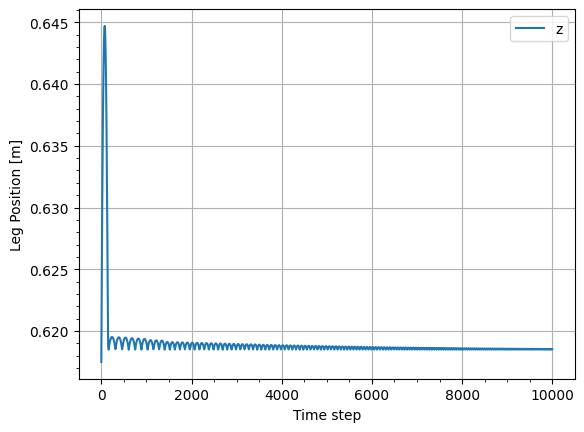

In [223]:
##plotting positions
plt.figure('Leg positions')
#plt.plot(leg_positions_x, label='x')
#plt.plot(leg_positions_y, label='y')
plt.plot(leg_position_z, label='z')
plt.xlabel('Time step')
plt.ylabel('Leg Position [m]')
plt.legend()
plt.grid()
plt.minorticks_on()
#plt.ylim(leg_position_z[-1],leg_position_z[9000])
#plt.xlim(9000,10000)
plt.show()

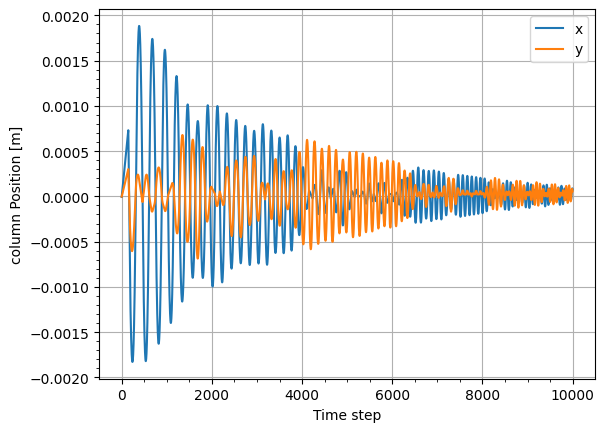

In [224]:
#plot column positions
plt.figure('column')
plt.plot(column_positions_x, label='x')
plt.plot( column_positions_y, label='y')
#plt.plot(column_positions_z, label='z')
plt.xlabel('Time step')
plt.ylabel('column Position [m]')
plt.legend()
plt.grid()
plt.minorticks_on()
#plt.ylim(-0.05,0.0000)
#plt.xlim(50, 500)
plt.show()

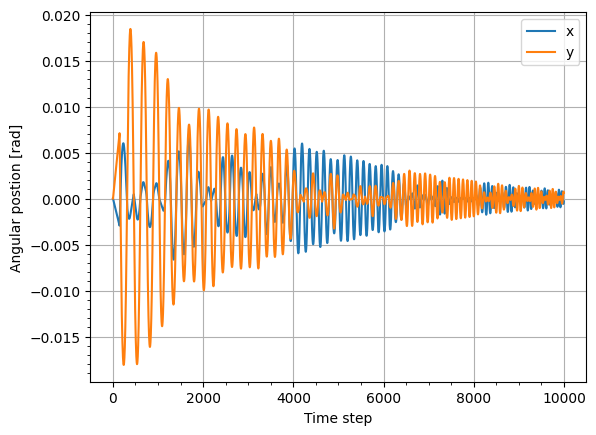

In [225]:
#plot elastic forces applied
plt.figure('Theta joint')
plt.plot(theta_joint_x, label='x')
plt.plot(theta_joint_y, label='y')
plt.xlabel('Time step')
plt.ylabel('Angular postion [rad]')
plt.legend()
plt.grid()
#plt.xlim(49,200)
plt.minorticks_on()

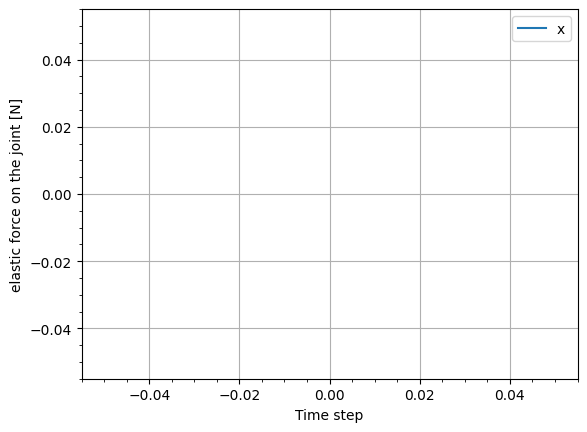

In [226]:
plt.figure('elastic force joint')
plt.plot(force_x_joint, label='x')
#plt.plot(force_y_joint, label='y')
plt.xlabel('Time step')
plt.ylabel('elastic force on the joint [N]')
plt.legend()
plt.grid()
plt.minorticks_on()
#plt.xlim(50,1500)

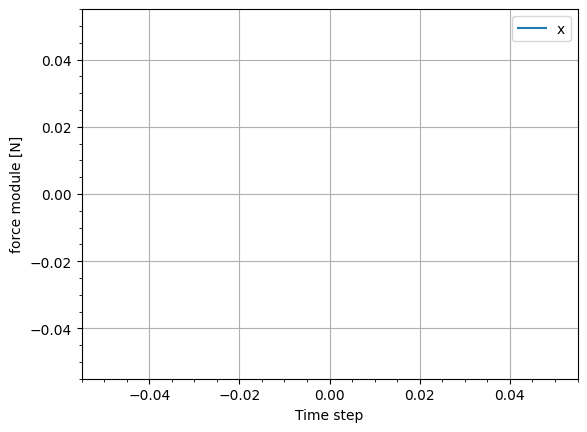

In [227]:
plt.figure('force module')
plt.plot(force_module_botta, label='x')
plt.xlabel('Time step')
plt.ylabel('force module [N]')
plt.legend()
plt.grid()
plt.minorticks_on()
